First, we clone the repository that contain the dataset


In [1]:
!git clone https://github.com/rslim087a/track


Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 13.68 MiB/s, done.
Updating files: 100% (12160/12160), done.


Importing the necessary libraries and frameworks

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential # to structure the neural
from sklearn.utils import shuffle # used for randomizing the order of elemetns in array .....
from keras.layers import Convolution2D, MaxPool2D, Dropout, Flatten, Dense , Conv2D # importing different types of layers
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

In [3]:
datadir= 'track'
columns=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data=pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)  # read the data from the driving_log.csv file that exists in the track directory
data.head() # display the data



,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.615438


In [4]:
#remove the path of the images from the data (keep the necessary informations(data))
def remove_path(path):
  head, tail= ntpath.split(path)
  return tail
data['center']=data['center'].apply(remove_path)
data['right']= data['right'].apply(remove_path)
data['left']= data['left'].apply(remove_path)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


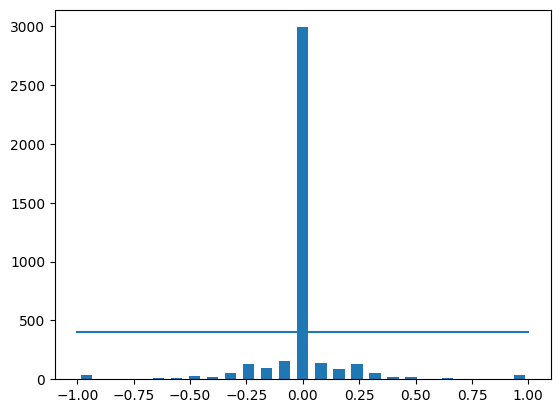

In [5]:
#displaying the data as a histogram (the number of accurance of a steering angle versus the steeting angle )
num_bins=25
samples_per_bin=400
hist, bins=np.histogram(data['steering'], num_bins)
center=(bins[:-1]+bins[1:])*0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))

In [6]:
print(data.shape)

(4053, 7)


In [7]:
# we remove the data when the we reach 400 data that have steering angle of 0 in order to have a good distribution
remove_list=[]
for j in range(num_bins):
  list_=[]
  for i in range( len(data['steering'])):
    if data['steering'][i]>= bins[j] and data['steering'][i]<=bins[j+1]:
      list_.append(i)
  list_=shuffle(list_)
  list_=list_[samples_per_bin:]
  remove_list.extend(list_)
print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

removed: 2590
remaining: 1463


# New section

<BarContainer object of 25 artists>

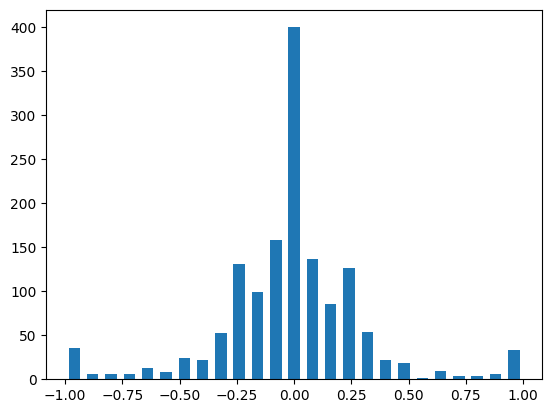

In [8]:
hist, bins=np.histogram(data['steering'], num_bins)
center=(bins[:-1]+bins[1:])*0.5
plt.bar(center, hist, width=0.05)

In [9]:
#this function returns the images paths and the corresponding steering angles in to lists (image_path and steerings)
def load_img_steering(datadir, df):
  image_path = []
  steering= []
  for i in range(len(data)):
    indexed_data=data.iloc[i]# taking one row from the data
    center, left, right= indexed_data[0], indexed_data[1], indexed_data[2]# assigningcenter , left and right images
    image_path.append(os.path.join(datadir, center.strip()))# appending the center image into the list named image_path
    steering.append(float(indexed_data[3]))
    #left image append
    image_path.append(os.path.join(datadir,left.strip()))
    steering.append(float(indexed_data[3] +0.15))
    #right image append
    image_path.append(os.path.join(datadir, right.strip()))
    steering.append(float(indexed_data[3]-0.15))
  image_paths= np.asarray(image_path)
  steerings=np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir+'/IMG', data)



In [10]:
print(len(image_paths))
print(len(steerings))


4389
4389


In [11]:
#split the data into training set and validation set
x_train, x_valid, y_train, y_valid= train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('training Samples: {}\nValid Samples : {}'.format(len(x_train), len(x_valid)))

training Samples: 3511
Valid Samples : 878


Augmentation of data


In [12]:
# defining the zoom function
def zoom(image):
  zoom=iaa.Affine(scale=(1,1.3)) # SPECIFYING THE SCALE FO THE ZOOM
  image=zoom.augment_image(image) # applying the zoom on the image
  return image    # returning the image



Text(0.5, 1.0, 'zoomed image')

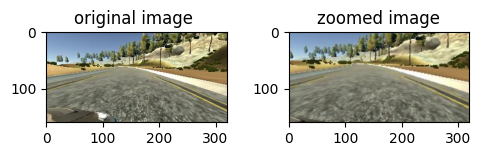

In [13]:
#testing the zoom function
image= image_paths[random.randint(0,1000)]
original_image= plt.imread(image)
zoomed_image=zoom(original_image)
fig, axs = plt.subplots(1,2, figsize=(5, 5))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("original image ")
axs[1].imshow(zoomed_image)
axs[1].set_title("zoomed image")



panning: moving the image in the x or y direction:


In [14]:
def pan(image):
  pan=iaa.Affine(translate_percent={"x": (-0.1,0.1), "y": (-0.1,0.1)})
  image= pan.augment_image(image)
  return image


Text(0.5, 1.0, 'panned image')

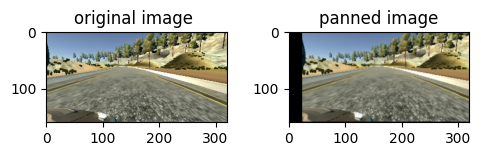

In [15]:
# test the pan function
image= image_paths[random.randint(0,1000)]
original_image= plt.imread(image)
panned_image=pan(original_image)
fig, axs = plt.subplots(1,2, figsize=(5, 5))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("original image ")
axs[1].imshow(panned_image)
axs[1].set_title("panned image")

changing the brightness of the image :

In [16]:
def img_brightness(image):
  bright=iaa.Multiply((0.2,1.2))
  image=bright.augment_image(image)
  return image

Text(0.5, 1.0, 'image with brightness')

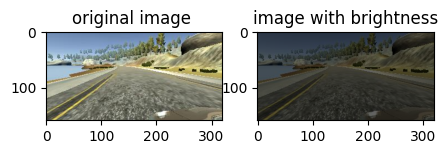

In [17]:
#testing the img_brightness function
image=image_paths[(random.randint(0,1000))]
original_image=plt.imread(image)
bright_image=img_brightness(original_image)
fig, axs=plt.subplots(1,2,figsize=(5,5))
axs[0].imshow(original_image)
axs[0].set_title("original image ")
axs[1].imshow(bright_image)
axs[1].set_title("image with brightness")

Text(0.5, 1.0, 'image with brightness steering angle:0.3833759')

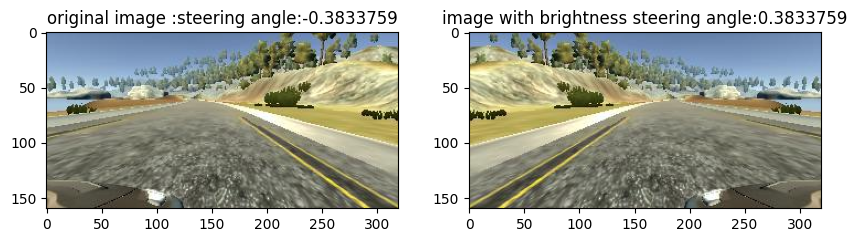

In [18]:
# flip the image
def image_flip(image, steering_angle):
  image= cv2.flip(image,1)# the number one is for horizontal flipping
  steering_angle=-steering_angle
  return image, steering_angle
indx= random.randint(0,1000)
image=image_paths[indx]
steering_angle=steerings[indx]
original_image=plt.imread(image)
flipped_image, steer =image_flip(original_image,steering_angle )
fig, axs=plt.subplots(1,2,figsize=(10,10))
axs[0].imshow(original_image)
axs[0].set_title("original image :" + "steering angle:" + str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title("image with brightness" + " steering angle:" + str(steer))

In [19]:
# this function chose randomly one of the above function to be excuted
def random_augment(image, steering_angle):
  image=plt.imread(image)
  if np.random.rand()<0.5:
    image=pan(image)
  if np.random.rand()<0.5:
    image=zoom(image)
  if np.random.rand()< 0.5:
    image=img_brightness(image)
  if np.random.rand()< 0.5:
    image,steering_angle = image_flip(image, steering_angle)
  return image , steering_angle



In [20]:
#rgb to YUV conversion
def img_processing(image):
  image=image[60:135,:,:]
  image=cv2.cvtColor(image,cv2.COLOR_RGB2YUV)
  image=cv2.GaussianBlur(image, (3,3), 0)
  image=cv2.resize(image, (200,66))
  image=image/255
  return image

(160, 320, 3)
(66, 200, 3)


Text(0.5, 1.0, ' image processed ')

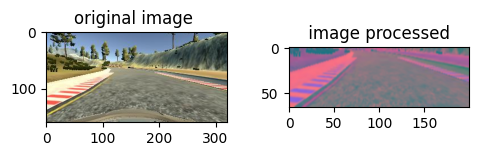

In [21]:
#
image1=image_paths[120]
image1=plt.imread(image1)
print(image1.shape)
processed_image=img_processing(image1)
print(processed_image.shape)
fig, axs= plt.subplots(1,2, figsize=(5,5))
fig.tight_layout()

axs[0].imshow(image1)
axs[0].set_title("original image ")
axs[1].imshow(processed_image)
axs[1].set_title(" image processed ")


In [22]:
# this function generate batches from the data set
def batch_generator(image_paths, steering_angle, batch_size,istraining):
  while True :
      batch_image=[] # creating an empty list to store the batch data
      batch_steering=[]
      for _ in range(batch_size):

          indx= random.randint(0,len(image_paths)-1)
          if istraining :
            img , steer =random_augment(image_paths[indx], steering_angle[indx])
          else :
            img=plt.imread(image_paths[indx])
            steer=steering_angle[indx]
          img=img_processing(img)
          batch_image.append(img)
          batch_steering.append(steer)
      yield(np.asarray(batch_image), np.asarray(batch_steering))
x_trainaug,  y_trainaug =next(batch_generator(x_train, y_train, 1,0))
x_valaug, y_valaug=next(batch_generator(x_valid, y_valid, 1,1))



Text(0.5, 1.0, 'validation_batch')

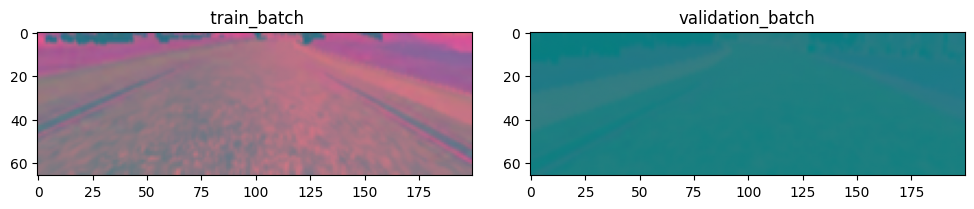

In [23]:
fig, axs= plt.subplots(1,2,figsize=(10,15))
fig.tight_layout()
axs[0].imshow(x_trainaug[0])
axs[0].set_title(" train_batch")
axs[1].imshow(x_valaug[0])
axs[1].set_title("validation_batch")

In [24]:
#CONSTRUCTING THE THE NEURAL NETWORK ARCHITECHTURE(based on nvidea model)
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(64, (5, 5),padding='same', activation='elu'))
  model.add(Conv2D(64, (3,3),padding='same', activation='elu'))
  model.add(Dropout(0.5))


  model.add(Flatten())

  model.add(Dense(100, activation = 'elu'))
  model.add(Dropout(0.5))

  model.add(Dense(50, activation = 'elu'))
  model.add(Dropout(0.5))

  model.add(Dense(10, activation = 'elu'))
  model.add(Dropout(0.5))

  model.add(Dense(1))

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

model = nvidia_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 22, 64)         76864     
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 22, 64)         36928     
                                                                 
 dropout (Dropout)           (None, 5, 22, 64)         0         
                                                                 
 flatten (Flatten)           (None, 7040)              0

In [25]:
# running our model on GPU INORDER TO SPEED UP THE COMPUTATIONS
with tf.device('/device:GPU:0'):
    history = model.fit_generator(generator=batch_generator(x_train, y_train, 100,1),
                              validation_data=batch_generator(x_valid, y_valid, 100, 0),
                              epochs=10,
                              steps_per_epoch=300,
                              validation_steps=200,
                              verbose=1,
                              shuffle=1)


<ipython-input-25-5586a1d0c9b6>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=batch_generator(x_train, y_train, 100,1),


Epoch 1/10
300/300 [==============================] - 152s 476ms/step - loss: 0.5981 - val_loss: 0.0849
Epoch 2/10
300/300 [==============================] - 125s 418ms/step - loss: 0.1007 - val_loss: 0.0779
Epoch 3/10
300/300 [==============================] - 125s 419ms/step - loss: 0.0933 - val_loss: 0.0718
Epoch 4/10
300/300 [==============================] - 135s 452ms/step - loss: 0.0916 - val_loss: 0.0702
Epoch 5/10
300/300 [==============================] - 131s 438ms/step - loss: 0.0879 - val_loss: 0.0683
Epoch 6/10
300/300 [==============================] - 167s 559ms/step - loss: 0.0887 - val_loss: 0.0650
Epoch 7/10
300/300 [==============================] - 159s 531ms/step - loss: 0.0868 - val_loss: 0.0643
Epoch 8/10
300/300 [==============================] - 113s 378ms/step - loss: 0.0827 - val_loss: 0.0631
Epoch 9/10
300/300 [==============================] - 141s 470ms/step - loss: 0.0826 - val_loss: 0.0642
Epoch 10/10
300/300 [==============================] - 112s 376m

Text(0.5, 0, 'Epochs')

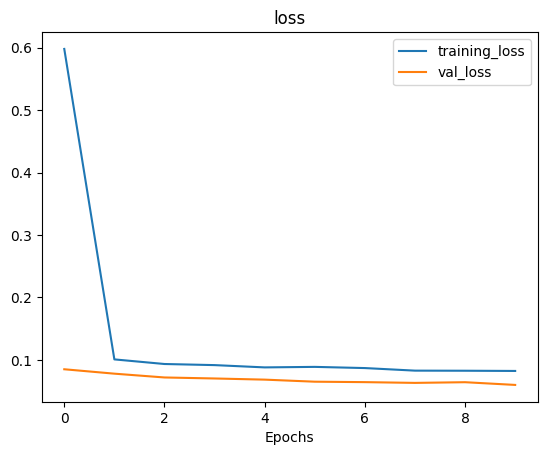

In [32]:
#ploting hte loss ufnction
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training_loss', 'val_loss'])
plt.title('loss')
plt.xlabel('Epochs')


In [27]:
#saving the model and download it as an h5 file
model.save('model.h5')
from google.colab import files
files.download('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>